### First set number of cores on machine to use and SSID number to analyse, then run all

In [1]:
# setting variables

cores = 3 # enter the number of cores to use here, in place of x
SSIDno = 510052 # enter the SSID number to model as an int here, in place of xxxxxxxx

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
#import matplotlib.font_manager as fm
import matplotlib
import autotime
%matplotlib inline
%load_ext autotime
#import seaborn as sns
import statsmodels as stm
import statsmodels.formula.api as sm
from sklearn.feature_selection import VarianceThreshold
from sklearn import metrics
from sklearn.linear_model import LinearRegression as LinR
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV as RSCV
# from dask_searchcv import RandomizedSearchCV as DRSCV
# from sklearn.pipeline import Pipeline
from sklearn.metrics.scorer import make_scorer
# from sklearn.preprocessing import MinMaxScaler as MMS
from scipy import stats
from scipy.stats import randint

#from sklearn.tree import export_graphviz
#from IPython.display import Image

## 1. Data processing stage

First, select route files to input based on SSIDno to analyse

### 1a Inputting data and creating dataframe for SSIDno

In [3]:
# Read in stop_times.txt and trips.txt files from NTA data
stop_times_2012 = pd.read_csv('stop_times.txt')
trips_2012 = pd.read_csv('trips.txt')

# Merge by trip_id
merge = pd.merge(stop_times_2012, trips_2012, on='trip_id', how='outer')

# Keep only necessary columns
merge.drop(['arrival_time','departure_time','pickup_type','drop_off_type','service_id','shape_dist_traveled'], axis=1, inplace=True)

# Transform trip_id to route and stop_id to StopID
merge['route_short'] = merge['trip_id'].apply(lambda x: x[x.index('-')+1:])
merge['route_short'] = merge['route_short'].apply(lambda x: x[: x.index('-')])
merge['route_short'] = merge['route_short'].apply(lambda x: str(x).zfill(4))
merge['StopID'] = merge['stop_id'].apply(lambda x: x[-4:])

# Find StopID and the sequence of that shape_id
gb = merge.groupby(['shape_id', 'route_short', 'direction_id','stop_sequence', 'StopID'])
gbc = gb.count()
gbc.reset_index(['shape_id', 'route_short', 'direction_id','stop_sequence', 'StopID'], inplace=True)
transit_shapeID_stopID = gbc.drop(['trip_id','stop_id','route_id','trip_headsign'], axis=1)

# create list of pairs of routes and the SSIDs contained within them
ssid = []
for i in range(len(transit_shapeID_stopID.index)-1):
    temp = transit_shapeID_stopID['StopID'].iloc[i] + transit_shapeID_stopID['StopID'].iloc[i+1]
    ssid.append([ transit_shapeID_stopID['route_short'].iloc[i],temp])
    
SSIDnoStr = str(SSIDno).zfill(8)
routes = [x for x in ssid if SSIDnoStr in x[1]]
routes = [item[0] for item in routes]
routes = list(set(routes))

# Reading in the route CSV files for the required SSID

res = pd.read_csv('Route_XXXX_travel_time_csvs/Blank_Route_travel_time.csv')
route_list = routes
for r in route_list:
    df = pd.read_csv('Route_XXXX_travel_time_csvs/Route_%s_travel_time.csv' % r)
    res = pd.concat([df, res], axis=0) 

time: 12.4 s


In [4]:
# create dataframe for SSIDno

res['SSID'] = res['SSID'].astype('category')
ssid_df = res[res.SSID == SSIDno]
ssid_df.reset_index(inplace=True)
ssid_df = ssid_df.drop('index', axis=1)
ssid_df.shape

(25259, 12)

time: 345 ms


In [5]:
ssid_df.memory_usage(deep=True)

Index                    80
Day                 1622433
DestStopID           202072
HourFrame            202072
JourneyPatternID    1047799
Rain                 202072
SSID                 447958
SchoolHoliday         25259
SourceStopID         202072
TimeFrame           1692353
TravelTime           202072
VehicleJourneyID     202072
WindSpeed            202072
dtype: int64

time: 11 ms


In [6]:
JPID_Count = ssid_df.JourneyPatternID.unique().shape[0]
Row_Count = ssid_df.shape[0]
print("There are", JPID_Count, "unique JPIDs traversing this segment, over the course of", Row_Count, "observations.")

There are 38 unique JPIDs traversing this segment, over the course of 25259 observations.
time: 5 ms


In [7]:
# add leading zeroes to JourneyPatternID

ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.astype('object')
ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.apply(lambda x: str(x).zfill(8))

time: 19 ms


### 1b Adding extra features and altering/dropping existing ones

In [8]:
# adding Xbuses feature - boolean feature indicating whether or not the JourneyPatternID represents an express (X) bus

ssid_df['XBuses'] = ssid_df[ssid_df["JourneyPatternID"].str.find("X") > 0].sum(axis=1) > 0
ssid_df["XBuses"].fillna(False, inplace=True)
ssid_df['XBuses'] = ssid_df['XBuses'].astype('int')

time: 20 ms


In [9]:
# adding JPID_length feature - represents the total number of stops traversed by this JourneyPatternID along its entire route

JPIDL = pd.read_csv('JPID_Length.csv')
JPIDL = JPIDL.drop('Unnamed: 0', axis=1)
ssid_df = pd.merge(left=ssid_df ,right=JPIDL, how='left', left_on='JourneyPatternID', right_on='JourneyPatternID')
ssid_df = ssid_df.dropna()
ssid_df.shape

(25259, 14)

time: 28 ms


In [10]:
# NOTE: feature currently not being used due to issues with inputting it to the model

# adding JPID_Freq feature - represents how often in the given data this JourneyPatternID traversed this segment

# ssid_df['JPID_Freq'] = ssid_df.groupby(['JourneyPatternID'])['JourneyPatternID'].transform('count')

time: 1e+03 µs


In [11]:
# removing non-holiday-period weekends from SchoolHoliday feature to avoid multi-collinearity issues

ssid_df['SchoolHoliday'] = ssid_df['SchoolHoliday'].astype('int')
ssid_df['SchoolHoliday'] = np.where(ssid_df['TimeFrame'].isin(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05', '2013-01-06']), 1, 0)

time: 6 ms


In [12]:
# fetching SSID number from dataframe for CSV file naming purposes

res.SSID = res.SSID.apply(lambda x: str(int(x)).zfill(8))
r = ssid_df.loc[0, 'SSID'] 

time: 32 ms


In [13]:
# dropping unneeded columns

ssid_df = ssid_df.drop(['SourceStopID', 'DestStopID', 'VehicleJourneyID', 'JourneyPatternID', 'SSID'], axis=1)

# reordering remaining columns

ssid_df = ssid_df[['TravelTime', 'Rain', 'WindSpeed', 'JPID_length', 'XBuses', 'SchoolHoliday', 'Day', 'HourFrame']]

time: 5 ms


In [14]:
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,XBuses,SchoolHoliday,Day,HourFrame
0,41,0.000000,12.0,62,0,0,Tuesday,6
1,61,0.000000,15.5,62,0,0,Tuesday,9
2,20,0.000000,17.5,62,0,0,Tuesday,12
3,20,0.000000,17.0,62,0,0,Tuesday,14
4,121,0.000000,14.0,62,0,0,Tuesday,17
5,78,0.000000,15.0,62,0,0,Tuesday,20
6,100,0.000000,15.0,62,0,0,Tuesday,8
7,60,0.000000,17.5,62,0,0,Tuesday,11
8,22,0.000000,17.0,62,0,0,Tuesday,13
9,100,0.000000,15.5,62,0,0,Tuesday,16


time: 25 ms


In [15]:
# assigning appropriate datatypes where necessary

ssid_df['Day'] = ssid_df['Day'].astype('category')
ssid_df['HourFrame'] = ssid_df['HourFrame'].astype('category')
ssid_df['JPID_length'] = ssid_df['JPID_length'].astype('int')

time: 34 ms


In [16]:
# removing any constant features
# code from: https://stackoverflow.com/questions/20209600/panda-dataframe-remove-constant-column

ssid_df = ssid_df.loc[:,ssid_df.apply(pd.Series.nunique) != 1]

time: 17 ms


In [17]:
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,SchoolHoliday,Day,HourFrame
0,41,0.000000,12.0,62,0,Tuesday,6
1,61,0.000000,15.5,62,0,Tuesday,9
2,20,0.000000,17.5,62,0,Tuesday,12
3,20,0.000000,17.0,62,0,Tuesday,14
4,121,0.000000,14.0,62,0,Tuesday,17
5,78,0.000000,15.0,62,0,Tuesday,20
6,100,0.000000,15.0,62,0,Tuesday,8
7,60,0.000000,17.5,62,0,Tuesday,11
8,22,0.000000,17.0,62,0,Tuesday,13
9,100,0.000000,15.5,62,0,Tuesday,16


time: 23 ms


In [18]:
# save as csv

ssid_df.to_csv('SSID_CSVs/SSID_%s.csv' % r)

time: 164 ms


## 1c. Dropping Outliers

#### Visualising range of travel-time data first

Histiogram of values (x-axis is number of seconds)

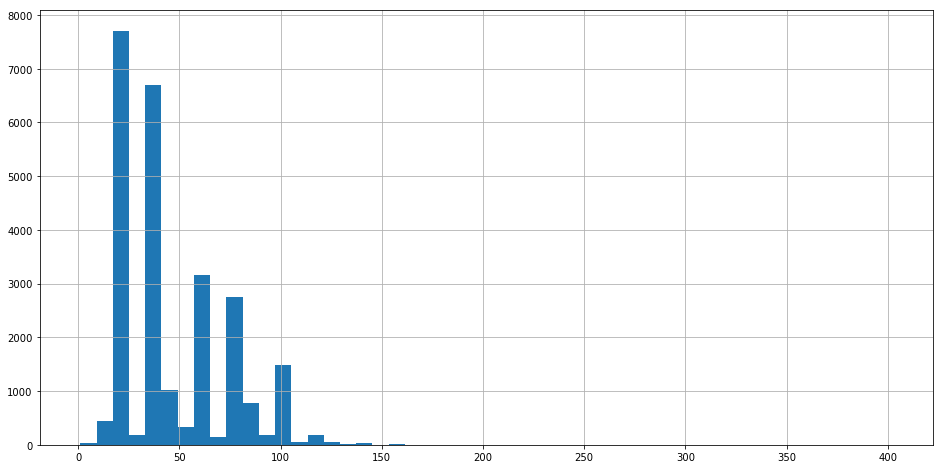

time: 232 ms


In [19]:
ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)

Boxplot to check for outliers

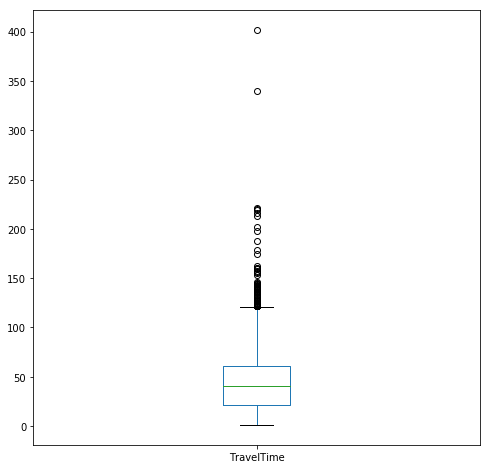

time: 252 ms


In [20]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

In [21]:
# Checking stats for TravelTime

ssid_df.TravelTime.describe()

count    25259.000000
mean        47.008947
std         26.665109
min          1.000000
25%         21.000000
50%         41.000000
75%         61.000000
max        402.000000
Name: TravelTime, dtype: float64

time: 7 ms


Dropping outliers

In [22]:
# loading table of minimum times to traverse segments at 65kmph

find_lb = pd.read_csv('use_speed_and_distance_get_outlier_bound.csv')

# extracting value for this segment, to use as lower bound for outlier removal

lb = find_lb.loc[find_lb['SSID'] == SSIDno, 'min_sec'].iloc[0]
print(lb)

8.62081178308
time: 10 ms


In [23]:
# make a copy of original df

trimssid_df = ssid_df.copy()

# Remove TravelTime upper bound outliers beyond a conservative 2 x IQR, and lowerbound below 'lb'

ub = trimssid_df.quantile(q=.75) + (2*(trimssid_df.quantile(q=.75)-trimssid_df.quantile(q=.25)))
trimssid_df['OutlierTT'] = (trimssid_df['TravelTime'] < lb) | (trimssid_df['TravelTime'] > ub['TravelTime'])

# Outlier rows counted

print("There will be", trimssid_df[(trimssid_df['OutlierTT'] == True)].shape[0], "outliers dropped.")

There will be 50 outliers dropped.
time: 15 ms


In [24]:
# dropping outliers

trimssid_df = trimssid_df[trimssid_df.OutlierTT != True]
trimssid_df.sort_values(['TravelTime'], ascending=False, inplace=True)
trimssid_df = trimssid_df.drop(['OutlierTT'], axis=1)
trimssid_df.reset_index(inplace=True)
trimssid_df = trimssid_df.drop('index', axis=1)
trimssid_df

,TravelTime,Rain,WindSpeed,JPID_length,SchoolHoliday,Day,HourFrame
0,141,0.000000,14.5,42,0,Monday,11
1,141,0.000000,4.0,53,0,Friday,13
2,141,0.000000,2.0,53,0,Thursday,9
3,141,0.000000,20.5,62,0,Monday,8
4,141,0.000000,8.0,93,0,Wednesday,15
5,140,0.000000,13.5,62,0,Friday,12
6,140,0.000000,5.0,62,0,Thursday,10
7,140,0.000000,10.0,80,0,Thursday,16
8,140,0.000000,2.0,93,0,Tuesday,17
9,139,0.666504,16.0,93,0,Friday,9


time: 59 ms


In [25]:
# Create TT mean/median value variables, to use in calculating mean/median absolute percentage accuracy scores
# and for horizontal lines in the charts below to represent the mean/medium

ssid_df = trimssid_df
ssid_df_mean = ssid_df.TravelTime.mean()
ssid_df_median  = ssid_df.TravelTime.median()
ssid_df.TravelTime.describe()

count    25209.000000
mean        46.892181
std         26.189055
min          9.000000
25%         21.000000
50%         41.000000
75%         61.000000
max        141.000000
Name: TravelTime, dtype: float64

time: 8 ms


#### Visualising range of data after dropping outliers

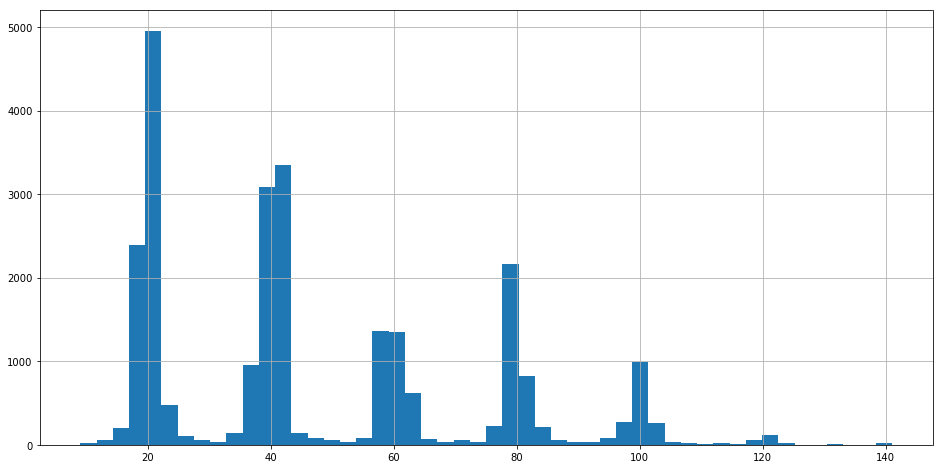

time: 207 ms


In [26]:
ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)

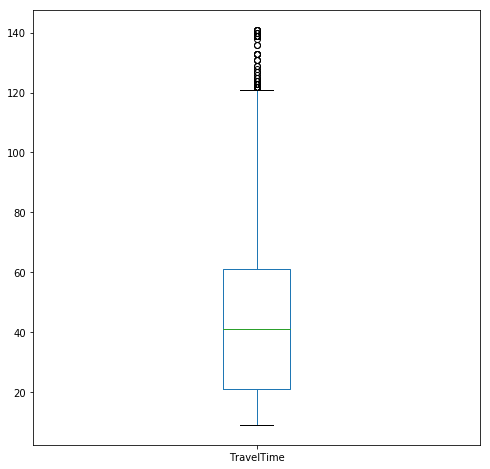

time: 246 ms


In [27]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

## 2. Visualising the data

### 2ai Bar plot for mean TravelTime per HourFrame

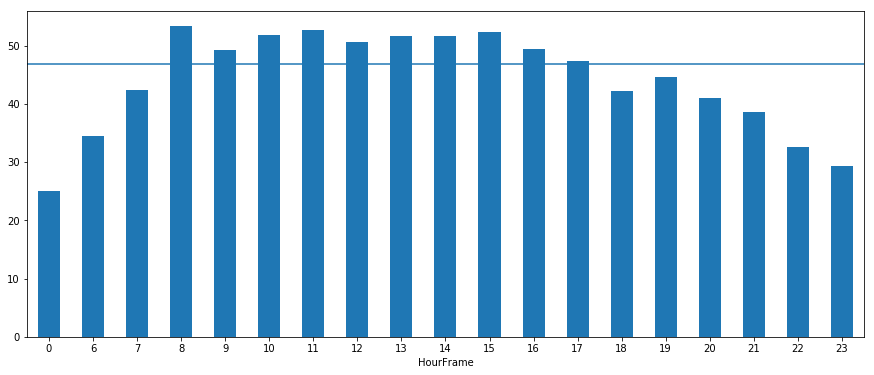

time: 186 ms


In [28]:
mean_HF = ssid_df.groupby('HourFrame')['TravelTime'].mean()
mean_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2aii Bar plot for median TravelTime per HourFrame

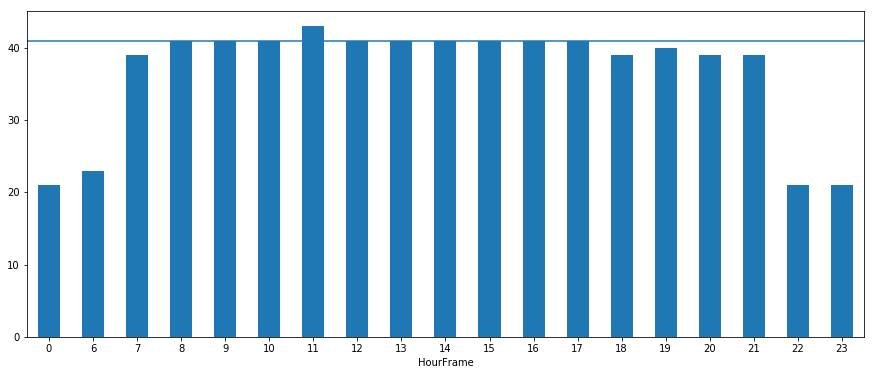

time: 180 ms


In [29]:
med_HF = ssid_df.groupby('HourFrame')['TravelTime'].median()
med_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2bi Bar plot for mean TravelTime per Day

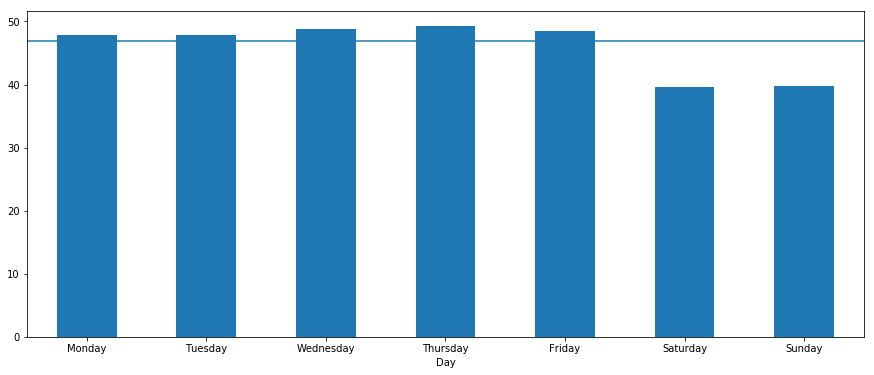

time: 144 ms


In [30]:
mean_Day = ssid_df.groupby('Day')['TravelTime'].mean()
mean_Day=mean_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

mean_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean

coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2bii Bar plot for median TravelTime per HourFrame

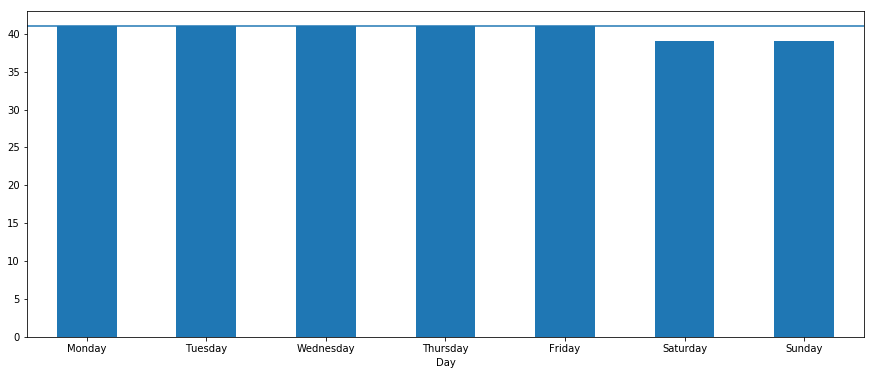

time: 149 ms


In [31]:
med_Day = ssid_df.groupby('Day')['TravelTime'].median()

med_Day=med_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
med_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation: 

### 2ci Bar plot for mean TravelTime when SchoolHoliday true/false

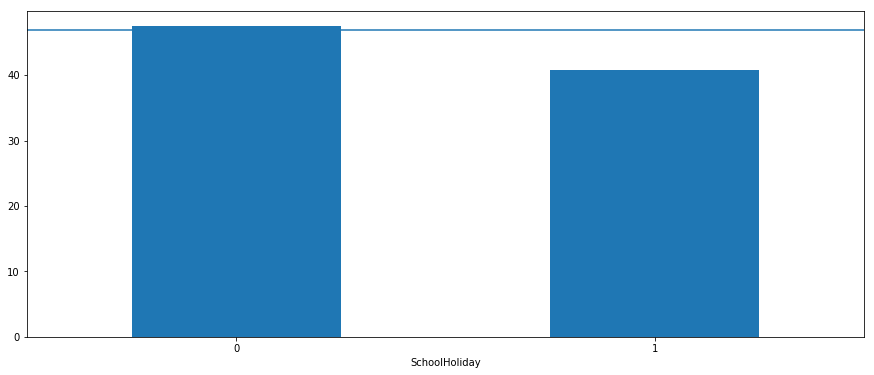

time: 156 ms


In [32]:
mean_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].mean()
mean_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2cii Bar plot for median TravelTime when SchoolHoliday true/false

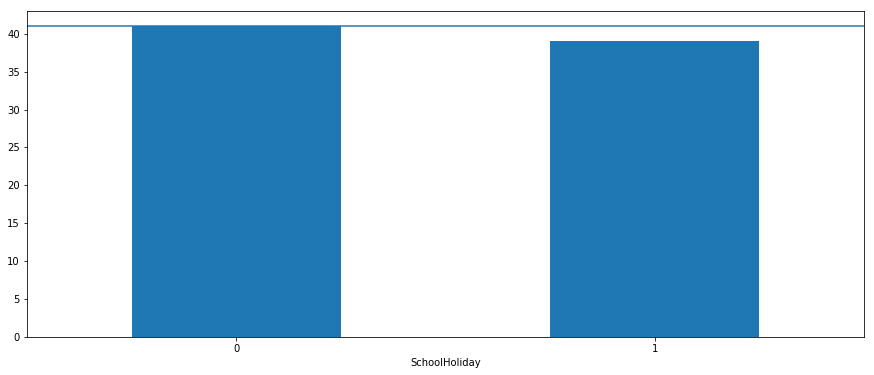

time: 128 ms


In [33]:
med_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].median()
med_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Splitting data into 70% for training and 30% for testing

## 3 Model training (Scikit-learn)

First we need to dreate dummy variables for categorical features, and split into test and training sets

### 3.1 Prepare data for modelling via Scikit-learn

In [34]:
# create dummy variables from HourFrame and Day using get_dummies
# dropping first values to avoid multicollinearity (Day = Friday, Hour = 0 or 6 or 7, depending on SSID)

Day_dummies = pd.get_dummies(ssid_df.Day, prefix='Day', drop_first=True)
HF_dummies = pd.get_dummies(ssid_df.HourFrame, prefix='HF', drop_first=True)

# concatenate the dummy variable columns onto the original DataFrame and drop the original features
ssid_df = pd.concat([ssid_df, HF_dummies, Day_dummies], axis=1)
ssid_df = ssid_df.drop(['HourFrame', 'Day'], axis=1)
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,SchoolHoliday,HF_6,HF_7,HF_8,HF_9,HF_10,...,HF_20,HF_21,HF_22,HF_23,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,141,0.000000,14.5,42,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,141,0.000000,4.0,53,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,141,0.000000,2.0,53,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,141,0.000000,20.5,62,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,141,0.000000,8.0,93,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,140,0.000000,13.5,62,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,140,0.000000,5.0,62,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
7,140,0.000000,10.0,80,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,140,0.000000,2.0,93,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9,139,0.666504,16.0,93,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


time: 54 ms


In [35]:
# prepare a list containing all remaining features bar the target
pred_features = list(ssid_df)
pred_features.remove('TravelTime')
print(pred_features)

['Rain', 'WindSpeed', 'JPID_length', 'SchoolHoliday', 'HF_6', 'HF_7', 'HF_8', 'HF_9', 'HF_10', 'HF_11', 'HF_12', 'HF_13', 'HF_14', 'HF_15', 'HF_16', 'HF_17', 'HF_18', 'HF_19', 'HF_20', 'HF_21', 'HF_22', 'HF_23', 'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday']
time: 1 ms


In [36]:
# prepare target/predictive feature variables for use in scikit-learn modelling

X = ssid_df[pred_features]
y = ssid_df['TravelTime']

time: 3 ms


In [37]:
# split the data into training portion (70%) and final testing potion (30%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 38)

time: 6 ms


### 3bi Linear Regression model (via scikit-learn) - training - default parameters

In [38]:
lr = LinR(n_jobs = cores)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=3, normalize=False)

time: 67 ms


In [39]:
lr_pred = lr.predict(X_train)
lr_rsq = metrics.r2_score(y_train, lr_pred)
print ("The R-squared value of the Linear Regression model is", lr_rsq)

The R-squared value of the Linear Regression model is 0.0859698758435
time: 6 ms


In [40]:
lr_mae = metrics.mean_absolute_error(y_train, lr_pred)
print ("The mean absolute error of the Linear Regression model is", lr_mae)
print ("The mean absolute percentage error is", (((lr_mae)/ssid_df_mean)*100))

The mean absolute error of the Linear Regression model is 20.76684591
The mean absolute percentage error is 44.2863720689
time: 4 ms


In [41]:
lr_mdae = metrics.median_absolute_error(y_train, lr_pred)
print ("The median absolute error of the Linear Regression model is", lr_mdae)
print ("The median absolute percentage error is", (((lr_mdae)/ssid_df_median)*100))

The median absolute error of the Linear Regression model is 18.6028611881
The median absolute percentage error is 45.372832166
time: 5 ms


### 3bii Linear Regression model (via scikit-learn) - testing - default parameters

In [42]:
lr_preda = lr.predict(X_test)
lr_rsqa = metrics.r2_score(y_test, lr_preda)
print ("The R-squared value of the Linear Regression model is", lr_rsqa)

The R-squared value of the Linear Regression model is 0.0796337759689
time: 5 ms


In [43]:
lr_maea = metrics.mean_absolute_error(y_test, lr_preda)
print ("The mean absolute error of the Linear Regression model is", lr_maea)
print ("The mean absolute percentage error is", (((lr_maea)/ssid_df_mean)*100))

The mean absolute error of the Linear Regression model is 20.7554368024
The mean absolute percentage error is 44.2620415573
time: 4 ms


In [44]:
lr_mdaea = metrics.median_absolute_error(y_test, lr_preda)
print ("The median absolute error of the Linear Regression model is", lr_mdaea)
print ("The median absolute percentage error is", (((lr_mdaea)/ssid_df_median)*100))

The median absolute error of the Linear Regression model is 18.3071699311
The median absolute percentage error is 44.6516339783
time: 6 ms


### 3ci Support Vector Machine Regression with RBF Kernel model - training - default parameters

In [45]:
svr_rbf = SVR(kernel='rbf')
svr_rbf.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

time: 18.8 s


In [46]:
svr_rbf_pred = svr_rbf.predict(X_train)
svr_rbf_rsq = metrics.r2_score(y_train, svr_rbf_pred)
print ("The R-squared value of the SVR with RBF Kernel model is", svr_rbf_rsq)

The R-squared value of the SVR with RBF Kernel model is -0.0119340899025
time: 11.3 s


In [47]:
svr_rbf_mae = metrics.mean_absolute_error(y_train, svr_rbf_pred)
print ("The mean absolute error of the SVR with RBF Kernel model is", svr_rbf_mae)
print ("The mean absolute percentage error is", (((svr_rbf_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with RBF Kernel model is 20.1032599183
The mean absolute percentage error is 42.8712406495
time: 2 ms


In [48]:
svr_rbf_mdae = metrics.median_absolute_error(y_train, svr_rbf_pred)
print ("The median absolute error of the SVR with RBF Kernel model is", svr_rbf_mdae)
print ("The median absolute percentage error is", (((svr_rbf_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with RBF Kernel model is 18.9863573951
The median absolute percentage error is 46.3081887685
time: 3 ms


### 3cii Support Vector Machine Regression with RBF Kernel model - testing - default parameters

In [49]:
svr_rbf_preda = svr_rbf.predict(X_test)
svr_rbf_rsqa = metrics.r2_score(y_test, svr_rbf_preda)
print ("The R-squared value of the SVR with RBF Kernel model is", svr_rbf_rsqa)

The R-squared value of the SVR with RBF Kernel model is -0.0185204987827
time: 4.84 s


In [50]:
svr_rbf_maea = metrics.mean_absolute_error(y_test, svr_rbf_preda)
print ("The mean absolute error of the SVR with RBF Kernel model is", svr_rbf_maea)
print ("The mean absolute percentage error is", (((svr_rbf_maea)/ssid_df_mean)*100))

The mean absolute error of the SVR with RBF Kernel model is 20.145232826
The mean absolute percentage error is 42.9607500442
time: 2 ms


In [51]:
svr_rbf_mdaea = metrics.median_absolute_error(y_test, svr_rbf_preda)
print ("The median absolute error of the SVR with RBF Kernel model is", svr_rbf_mdaea)
print ("The median absolute percentage error is", (((svr_rbf_mdaea)/ssid_df_median)*100))

The median absolute error of the SVR with RBF Kernel model is 19.0587500779
The median absolute percentage error is 46.4847562877
time: 2 ms


### 3di Gradient Boosting Regression model - training - default parameters

In [52]:
gbr = GBR()
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

time: 879 ms


In [53]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
JPID_length 	 0.2161677699
Day_Saturday 	 0.0641616744527
HF_22 	 0.0587801657294
WindSpeed 	 0.0582147587678
HF_23 	 0.057162809809
Rain 	 0.0551046124217
Day_Sunday 	 0.0497737773538
HF_6 	 0.0466300493929
HF_21 	 0.0419590080834
HF_18 	 0.041765298993
SchoolHoliday 	 0.0408548448379
HF_7 	 0.0402563280881
HF_8 	 0.0357236684466
HF_20 	 0.035349323884
HF_19 	 0.0231012482868
HF_15 	 0.0198943578524
HF_10 	 0.017142091689
HF_11 	 0.0162476707677
HF_12 	 0.0107098990915
HF_13 	 0.0105407370081
Day_Thursday 	 0.0103620563253
Day_Monday 	 0.00980842250663
HF_14 	 0.00967244191544
Day_Tuesday 	 0.00951535463724
HF_17 	 0.00810209491159
HF_9 	 0.006844329738
HF_16 	 0.00431198327125
Day_Wednesday 	 0.00184322183892
time: 63 ms


In [54]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
print ("The R-squared value of the Gradient Boosting Regression model is", gbr_rsq)

The R-squared value of the Gradient Boosting Regression model is 0.118086293941
time: 27 ms


In [55]:
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
print ("The mean absolute error of the Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))

The mean absolute error of the Gradient Boosting Regression model is 20.3573089986
The mean absolute percentage error is 43.4130134418
time: 2 ms


In [56]:
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The median absolute error of the Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The median absolute error of the Gradient Boosting Regression model is 18.6342983346
The median absolute percentage error is 45.4495081331
time: 3 ms


### 3dii Gradient Boosting Regression model - - testing - default parameters

In [57]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
print ("The R-squared value of the Gradient Boosting Regression model is", gbr_rsqa)

The R-squared value of the Gradient Boosting Regression model is 0.0991235843697
time: 13 ms


In [58]:
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
print ("The mean absolute error of the Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))

The mean absolute error of the Gradient Boosting Regression model is 20.494525635
The mean absolute percentage error is 43.7056350097
time: 3 ms


In [59]:
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The median absolute error of the Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

The median absolute error of the Gradient Boosting Regression model is 18.6604170409
The median absolute percentage error is 45.5132122948
time: 4 ms


### 3ei Random Forest Regression model (all default) - training - default parameters

In [149]:
rfr = RFR(n_jobs = cores, n_estimators=200, min_samples_leaf=5)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=3, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

time: 2.5 s


In [150]:
indices = np.argsort(rfr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", rfr.feature_importances_[indices[f]])

Ordered feature ranking:
WindSpeed 	 0.276050349409
JPID_length 	 0.165880718796
Rain 	 0.0739130512748
HF_22 	 0.0352514185453
HF_23 	 0.0351811138747
Day_Thursday 	 0.0266150951372
Day_Saturday 	 0.0259509840767
Day_Tuesday 	 0.0259393107279
Day_Wednesday 	 0.0252236880043
SchoolHoliday 	 0.0219015755061
Day_Sunday 	 0.0207410818272
HF_8 	 0.020426877161
Day_Monday 	 0.0198027476474
HF_18 	 0.0177907100993
HF_7 	 0.017520079604
HF_21 	 0.0166749226585
HF_17 	 0.0166207140336
HF_10 	 0.015928100022
HF_14 	 0.0157648528187
HF_15 	 0.0156997517283
HF_6 	 0.015548965869
HF_9 	 0.0154789855651
HF_20 	 0.0154259869306
HF_16 	 0.0141002195115
HF_13 	 0.0139341379295
HF_12 	 0.0124466343738
HF_19 	 0.0121987183142
HF_11 	 0.0119892085543
time: 2.95 s


In [151]:
rfr_pred = rfr.predict(X_train)
rfr_rsq = metrics.r2_score(y_train, rfr_pred)
print ("The R-squared value of the Random Forest Regression model is", rfr_rsq)

The R-squared value of the Random Forest Regression model is 0.314681941047
time: 313 ms


In [152]:
rfr_mae = metrics.mean_absolute_error(y_train, rfr_pred)
print ("The mean absolute error of the Random Forest Regression model is", rfr_mae)
print ("The mean absolute percentage error is", (((rfr_mae)/ssid_df_mean)*100))

The mean absolute error of the Random Forest Regression model is 17.5421484196
The mean absolute percentage error is 37.4095380284
time: 3 ms


In [153]:
rfr_mdae = metrics.median_absolute_error(y_train, rfr_pred)
print ("The median absolute error of the Random Forest Regression model is", rfr_mdae)
print ("The median absolute percentage error is", (((rfr_mdae)/ssid_df_median)*100))

The median absolute error of the Random Forest Regression model is 15.2958316346
The median absolute percentage error is 37.3069064258
time: 3 ms


### 3eii Random Forest Regression model (all default) - testing - default parameters

In [154]:
rfr_preda = rfr.predict(X_test)
rfr_rsqa = metrics.r2_score(y_test, rfr_preda)
print ("The R-squared value of the Random Forest Regression model is", rfr_rsqa)

The R-squared value of the Random Forest Regression model is 0.0484286148166
time: 208 ms


In [155]:
rfr_maea = metrics.mean_absolute_error(y_test, rfr_preda)
print ("The mean absolute error of the Random Forest Regression model is", rfr_maea)
print ("The mean absolute percentage error is", (((rfr_mae)/ssid_df_mean)*100))

The mean absolute error of the Random Forest Regression model is 20.7210415038
The mean absolute percentage error is 37.4095380284
time: 2 ms


In [156]:
rfr_mdaea = metrics.median_absolute_error(y_test, rfr_preda)
print ("The median absolute error of the Random Forest Regression model is", rfr_mdaea)
print ("The median absolute percentage error is", (((rfr_mdaea)/ssid_df_median)*100))

The median absolute error of the Random Forest Regression model is 18.340967314
The median absolute percentage error is 44.7340666194
time: 2 ms


## 4 All models bar Linear Regression - parameter tuning with RandomizedSearchCV

### 4a SVR with RandomizedSearchCV (scikit), Kfold 5, 5 iterations

In [68]:
svr = SVR()

# Parameter settings taken from:
# http://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/auto_examples/svm/plot_svm_parameters_selection.html
# https://www.quora.com/What-is-an-appropriate-grid-search-range-for-optimizing-the-parameter-epsilon-in-epsilon-support-vector-regression

C_range = 10. ** np.arange(-3, 6)
gamma_range = 10. ** np.arange(-5, 4)

param_svr = {'C': C_range,
            'gamma': gamma_range,
            'epsilon': [0, 0.01, 0.1, 0.5, 1, 2]}

time: 4 ms


In [69]:
svr_rsearch = RSCV(svr, param_distributions=param_svr, n_iter=38, cv=5, n_jobs=cores, scoring=make_scorer(metrics.median_absolute_error, greater_is_better=False))
svr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=38, n_jobs=3,
          param_distributions={'C': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03,   1.00000e+04,
         1.00000e+05]), 'gamma': array([  1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03]), 'epsilon': [0, 0.01, 0.1, 0.5, 1, 2]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True,
          scoring=make_scorer(median_absolute_error, greater_is_better=False),
          verbose=0)

time: 1h 18min 33s


In [70]:
print("Best parameters set found:")
print(svr_rsearch.best_params_)

Best parameters set found:
{'gamma': 0.10000000000000001, 'epsilon': 1, 'C': 100.0}
time: 1 ms


In [71]:
svr_train_MdAE = abs(svr_rsearch.best_score_)
svr_train_MdAPE = (svr_train_MdAE/ssid_df_median)*100

print("Best MdAE found is", svr_train_MdAE)
print ("Best MdAPE found is", str(round(svr_train_MdAPE, 3)) + "%")

Best MdAE found is 18.1390438214
Best MdAPE found is 44.242%
time: 4 ms


In [72]:
svr_rsearch_table = pd.DataFrame(svr_rsearch.cv_results_)
svr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
svr_rsearch_table = svr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_C', 'param_gamma', 'param_epsilon', 'mean_fit_time', 'mean_score_time']]
svr_rsearch_table.reset_index(inplace=True)
svr_rsearch_table = svr_rsearch_table.drop('index', axis=1)

print("Full ranked results for SVR RandomizedSearchCV:")
svr_rsearch_table

Full ranked results for SVR RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_C,param_gamma,param_epsilon,mean_fit_time,mean_score_time
0,1,-12.403609,-18.139044,100,0.1,1,17.8734,1.7798
1,2,-14.567856,-18.169456,10000,0.01,0,161.8058,1.9010
2,3,-12.433926,-18.243003,100,0.1,0.01,20.7376,2.0010
3,4,-18.114905,-18.283957,1000,0.001,0.01,13.8962,1.9010
4,5,-18.457688,-18.577415,100000,0.0001,0.01,46.1376,1.9506
5,6,-11.221529,-18.664813,10,1,0.01,17.0680,2.8068
6,7,-11.222015,-18.666229,10,1,0,17.3386,2.8124
7,8,-18.743011,-19.311564,1,10,0.1,18.2900,3.5400
8,9,-18.737000,-19.317088,1,10,0.01,18.4276,3.5022
9,10,-18.704398,-19.410202,1,100,1,17.9088,3.3824


time: 28 ms


In [73]:
# Running model on 30% test set

svr_test_pred = svr_rsearch.best_estimator_.predict(X_test)

svr_test_MdAE = metrics.median_absolute_error(y_test, svr_test_pred)
svr_test_MdAPE = (svr_test_MdAE/ssid_df_median)*100

print("MdAE of best model on the test set is", svr_test_MdAE)
print ("MdAPE of best model on the test set is", str(round(svr_test_MdAPE, 3)) + "%")

MdAE of best model on the test set is 18.0131476019
MdAPE of best model on the test set is 43.935%
time: 4.69 s


### 4b Gradient Boosted Regression with RandomizedSearchCV (scikit), Kfold 5, 5 iterations

In [74]:
gbr = GBR(loss='huber')

param_gbr = {'n_estimators': stats.randint(50, 5000),
            'max_depth': stats.randint(4, 9),
            'min_samples_leaf': stats.randint(5, 100),
            'min_samples_split': stats.randint(200, 1000),
            'learning_rate': stats.uniform(0.01, 0.6)}

time: 5 ms


In [75]:
gbr_rsearch = RSCV(gbr, param_distributions=param_gbr, n_iter=38, cv=5, n_jobs=cores, scoring=make_scorer(metrics.median_absolute_error, greater_is_better=False))
gbr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=38, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002A4259B0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002A4257B8>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002C6DBC88>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002C6DB9B0>, 'learning_rate': <scipy.stats._distn_inf

time: 58min 33s


In [76]:
print("Best parameters set found:")
print(gbr_rsearch.best_params_)

Best parameters set found:
{'learning_rate': 0.14784709488619563, 'max_depth': 7, 'min_samples_leaf': 8, 'min_samples_split': 617, 'n_estimators': 3153}
time: 1e+03 µs


In [77]:
gbr_train_MdAE = abs(gbr_rsearch.best_score_)
gbr_train_MdAPE = (gbr_train_MdAE/ssid_df_median)*100

print("Best MdAE found is", gbr_train_MdAE)
print ("Best MdAPE found is", str(round(gbr_train_MdAPE, 3)) + "%")

Best MdAE found is 17.8430540672
Best MdAPE found is 43.52%
time: 3 ms


In [78]:
gbr_rsearch_table = pd.DataFrame(gbr_rsearch.cv_results_)
gbr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
gbr_rsearch_table = gbr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_learning_rate', 'mean_fit_time', 'mean_score_time']]
gbr_rsearch_table.reset_index(inplace=True)
gbr_rsearch_table = gbr_rsearch_table.drop('index', axis=1)

print("Full ranked results for GBR RandomizedSearchCV:")
gbr_rsearch_table

Full ranked results for GBR RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_learning_rate,mean_fit_time,mean_score_time
0,1,-15.106105,-17.843054,3153,7,8,617,0.147847,88.4624,0.2994
1,2,-14.579412,-17.916444,320,7,20,297,0.495473,9.4828,0.0302
2,3,-16.567347,-17.917267,3750,4,94,838,0.330087,54.2044,0.1940
3,4,-13.710870,-17.927038,2845,7,98,555,0.442457,89.8128,0.3244
4,5,-15.643952,-17.928609,4709,5,71,554,0.285073,99.1446,0.3300
5,6,-15.612589,-17.929178,689,6,92,974,0.54074,14.4922,0.0558
6,7,-16.640295,-17.933177,2018,4,94,991,0.444768,27.4942,0.0974
7,8,-14.871981,-17.933823,2766,8,81,453,0.0924333,93.7908,0.3038
8,9,-15.667246,-17.937757,414,5,65,371,0.55285,7.7754,0.0288
9,10,-15.898524,-17.938742,444,6,49,849,0.459449,9.2584,0.0336


time: 33 ms


In [79]:
# Running model on 30% test set

gbr_test_pred = gbr_rsearch.best_estimator_.predict(X_test)

gbr_test_MdAE = metrics.median_absolute_error(y_test, gbr_test_pred)
gbr_test_MdAPE = (gbr_test_MdAE/ssid_df_median)*100

print("MdAE of best model on the test set is", gbr_test_MdAE)
print ("MdAPE of best model on the test set is", str(round(gbr_test_MdAPE, 3)) + "%")

MdAE of best model on the test set is 17.8731124947
MdAPE of best model on the test set is 43.593%
time: 659 ms


### 4c Random Forest Regression with RandomizedSearchCV (scikit), Kfold 5, 5 iterations

In [80]:
rfr = RFR()

param_rfr = {'n_estimators': stats.randint(50, 5000),
            'max_depth': stats.randint(4, 8),
            'min_samples_leaf': stats.randint(1, 20),
            'min_samples_split': stats.randint(1.0, 100)}

time: 4 ms


In [81]:
rfr_rsearch = RSCV(rfr, param_distributions=param_rfr, n_iter=38, cv=5, n_jobs=cores, scoring=make_scorer(metrics.median_absolute_error, greater_is_better=False))
rfr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=38, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000626EC88>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000626EBE0>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000626EF60>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000006278F98>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True,
          sco

time: 31min 7s


In [82]:
print("Best parameters set found:")
print(rfr_rsearch.best_params_)

Best parameters set found:
{'max_depth': 7, 'min_samples_leaf': 15, 'min_samples_split': 25, 'n_estimators': 3732}
time: 2 ms


In [83]:
rfr_train_MdAE = abs(rfr_rsearch.best_score_)
rfr_train_MdAPE = (rfr_train_MdAE/ssid_df_median)*100

print("Best MdAE found is", rfr_train_MdAE)
print ("Best MdAPE found is", str(round(rfr_train_MdAPE, 3)) + "%")

Best MdAE found is 19.6543796026
Best MdAPE found is 47.938%
time: 7 ms


In [84]:
rfr_rsearch_table = pd.DataFrame(rfr_rsearch.cv_results_)
rfr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
rfr_rsearch_table = rfr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'mean_fit_time', 'mean_score_time']]
rfr_rsearch_table.reset_index(inplace=True)
rfr_rsearch_table = rfr_rsearch_table.drop('index', axis=1)

print("Full ranked results for rfr RandomizedSearchCV:")
rfr_rsearch_table

Full ranked results for rfr RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_fit_time,mean_score_time
0,1,-19.343925,-19.654380,3732,7,15,25,46.4448,0.6282
1,2,-19.362155,-19.655948,3862,7,12,85,50.6578,0.6720
2,3,-19.322419,-19.658920,3830,7,13,42,47.5890,0.6320
3,4,-19.372358,-19.659659,427,7,15,90,5.2500,0.0692
4,5,-19.343418,-19.670781,3852,7,9,51,47.7048,0.6392
5,6,-19.322933,-19.673914,4593,7,5,10,57.3456,0.7658
6,7,-19.396157,-19.675995,392,7,6,98,4.8594,0.0646
7,8,-19.334243,-19.711871,3728,7,8,18,47.9884,0.6200
8,9,-19.299111,-19.751166,2383,7,2,6,30.1520,0.4056
9,10,-19.797580,-19.990541,454,6,16,3,4.9316,0.0664


time: 30 ms


In [85]:
# Running model on 30% test set

rfr_test_pred = rfr_rsearch.best_estimator_.predict(X_test)

rfr_test_MdAE = metrics.median_absolute_error(y_test, rfr_test_pred)
rfr_test_MdAPE = (rfr_test_MdAE/ssid_df_median)*100

print("MdAE of best model on the test set is", rfr_test_MdAE)
print ("MdAPE of best model on the test set is", str(round(rfr_test_MdAPE, 3)) + "%")

MdAE of best model on the test set is 19.2117712582
MdAPE of best model on the test set is 46.858%
time: 1.16 s
